In [1]:
import requests
import pandas as pd
import numpy as np
import re
import lxml.html as lx
import time
from bs4 import BeautifulSoup
import requests_cache
requests_cache.install_cache("hw4")
from tqdm import tqdm
import string
import nltk
import warnings
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

In [4]:
driver_path = " /Users/masheng/Library/Python/3.11/lib/python/site-packages"

options = webdriver.ChromeOptions()
options.add_argument(driver_path)

driver = webdriver.Chrome(options=options)

In [5]:
driver.get('https://glassdoor.com/Job/data-scientist-jobs-SRCH_KO0,14.htm')

In [ ]:
next_job_card = driver.find_element(By.CLASS_NAME,'JobsList_jobListItem__wjTHv')

i=0
all_job_details = pd.DataFrame(columns=['job_title','company_name','size','founded','type','industry','sector'])


In [33]:
next_job_card.get_attribute('class') == 'JobsList_jobListItem__wjTHv'

False

In [39]:
num=29

In [63]:
next_job_card = driver.find_elements(By.CLASS_NAME,'JobsList_jobListItem__wjTHv')[num+1]

In [77]:
len(driver.find_elements(By.CLASS_NAME,'JobsList_jobListItem__wjTHv'))

808

In [48]:
page = 1

In [64]:
while i<40:
    while next_job_card.get_attribute('class') == 'JobsList_jobListItem__wjTHv':
        job_card = next_job_card
        job_card.click()
        time.sleep(3)

        try:
            useless_window = driver.find_element(By.CLASS_NAME,'modal_main gdGrid css-1gy9wmw e8e8plt4')
            close = useless_window.find_element(By.CLASS_NAME,'SVGInline modal_closeIcon')
            click = close.click()
            time.sleep(2)
        except:
            pass

        job_details = pd.DataFrame({
            'job_title':None,'company_name':None,
            'size':None,'founded':None,'type':None,'industry':None,'sector':None}, index=[0])

        job_top = driver.find_element(By.CLASS_NAME,'JobDetails_jobDetailsHeader__Hd9M3')
        job_tops= job_top.text.split('\n')
        company_name = job_tops[0]
        job_title = job_tops[2]
        job_details['job_title'] = job_title
        job_details['company_name'] = company_name

        company_overview = driver.find_elements(By.CLASS_NAME,'JobDetails_overviewItem__cAsry')
        if company_overview:
            company_overview = [i.text.split('\n') for i in company_overview]
            job_details['size'] = company_overview[0][1]
            job_details['founded'] = company_overview[1][1]
            job_details['type'] = company_overview[2][1]
            job_details['industry'] = company_overview[3][1]
            job_details['sector'] = company_overview[4][1]

        all_job_details = pd.concat([all_job_details,job_details],ignore_index=True)
        num+=1

        next_job_card = job_card.find_element(By.XPATH, "following-sibling::li[1]")
    
    more_button = driver.find_element(By.XPATH, '//*[@id="left-column"]/div[2]/div/button')
    more_button.click()
    i+=1
    time.sleep(2)

    try:
        useless_window = driver.find_element(By.CLASS_NAME,'modal_main gdGrid css-1gy9wmw e8e8plt4')
        close = useless_window.find_element(By.CLASS_NAME,'SVGInline modal_closeIcon')
        click = close.click()
        time.sleep(2)
    except:
        pass

    next_job_card = driver.find_elements(By.CLASS_NAME,'JobsList_jobListItem__wjTHv')[num+1]

all_job_details

job_title  \
0                                       Data Scientist   
1              Staff Data Scientist - Matching Science   
2                                        United States   
3                                       Data Scientist   
4                                     Data Scientist I   
..                                                 ...   
802                                  Sr Data Scientist   
803  Senior Associate Data Scientist - Upmarket Seg...   
804                            Staff Applied Scientist   
805                       Data Scientist - Measurement   
806                                Senior Data Analyst   

                                company_name                     size founded  \
0                                 Activision   1001 to 5000 Employees    1979   
1                                     Indeed         10000+ Employees    2004   
2                              Behold Bev AI                     None    None   
3                               Tech Holding      51 to 200 Employees    2016   
4                   Vibrant Emotional Health     201 to 500 Employees      --   
..                                       ...                      ...     ...   
802                           Public Storage  5001 to 10000 Employees    1972   
803                              Capital One         10000+ Employees    1994   
804                                     Xero   1001 to 5000 Employees    2006   
805                                 InMarket     201 to 500 Employees    2010   
806  Philadelphia District Attorney's Office    501 to 1000 Employees      --   

                               type                                 industry  \
0    Subsidiary or Business Segment                    Video Game Publishing   
1                 Company - Private                  Internet & Web Services   
2                              None                                     None   
3                 Company - Private  Information Technology Support Services   
4            Nonprofit Organization                  Civic & Social Services   
..                              ...                                      ...   
802                Company - Public                              Real Estate   
803                Company - Public                        Banking & Lending   
804                Company - Public            Computer Hardware Development   
805               Company - Private                               Publishing   
806                      Government                       Municipal Agencies   

                                 sector  
0                 Media & Communication  
1                Information Technology  
2                                  None  
3                Information Technology  
4                       Nonprofit & NGO  
..                                  ...  
802                         Real Estate  
803                  Financial Services  
804              Information Technology  
805               Media & Communication  
806  Government & Public Administration  

[807 rows x 7 columns]

In [94]:
pd.DataFrame(all_job_details).to_csv('glassdorr_job_details.csv', index=False)

In [65]:
Analysis_df = all_job_details.copy()

In [68]:
Analysis_df['size'].value_counts()

size
10000+ Employees           268
1001 to 5000 Employees     136
1 to 50 Employees           87
51 to 200 Employees         78
5001 to 10000 Employees     58
Unknown                     57
201 to 500 Employees        47
501 to 1000 Employees       41
Name: count, dtype: int64

In [125]:
size_counts = Analysis_df['size'].value_counts()
size_counts = size_counts[size_counts.index != 'Unknown']
size_counts

size
10000+ Employees           268
1001 to 5000 Employees     136
1 to 50 Employees           87
51 to 200 Employees         78
5001 to 10000 Employees     58
201 to 500 Employees        47
501 to 1000 Employees       41
Name: count, dtype: int64

In [113]:
import circlify
# 气泡的位置分布
circles = circlify.circlify(size_counts.values.tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()

In [139]:
import seaborn as sns

In [126]:
size_counts = size_counts.to_frame()
print(size_counts)
total = size_counts['count'].sum()
print(total)
size_counts['percentage'] = round((size_counts['count'] / total) * 100,2)
print(size_counts)

                         count
size                          
10000+ Employees           268
1001 to 5000 Employees     136
1 to 50 Employees           87
51 to 200 Employees         78
5001 to 10000 Employees     58
201 to 500 Employees        47
501 to 1000 Employees       41
715
                         count  percentage
size                                      
10000+ Employees           268       37.48
1001 to 5000 Employees     136       19.02
1 to 50 Employees           87       12.17
51 to 200 Employees         78       10.91
5001 to 10000 Employees     58        8.11
201 to 500 Employees        47        6.57
501 to 1000 Employees       41        5.73


In [129]:
size_counts.index

Index(['10000+ Employees', '1001 to 5000 Employees', '1 to 50 Employees',
       '51 to 200 Employees', '5001 to 10000 Employees',
       '201 to 500 Employees', '501 to 1000 Employees'],
      dtype='object', name='size')

In [136]:
size_counts.index = size_counts.index.str.replace(' Employees', '')

In [137]:
size_counts.index

Index(['10000+', '1001 to 5000', '1 to 50', '51 to 200', '5001 to 10000',
       '201 to 500', '501 to 1000'],
      dtype='object', name='size')

In [132]:
import matplotlib.cm as cm

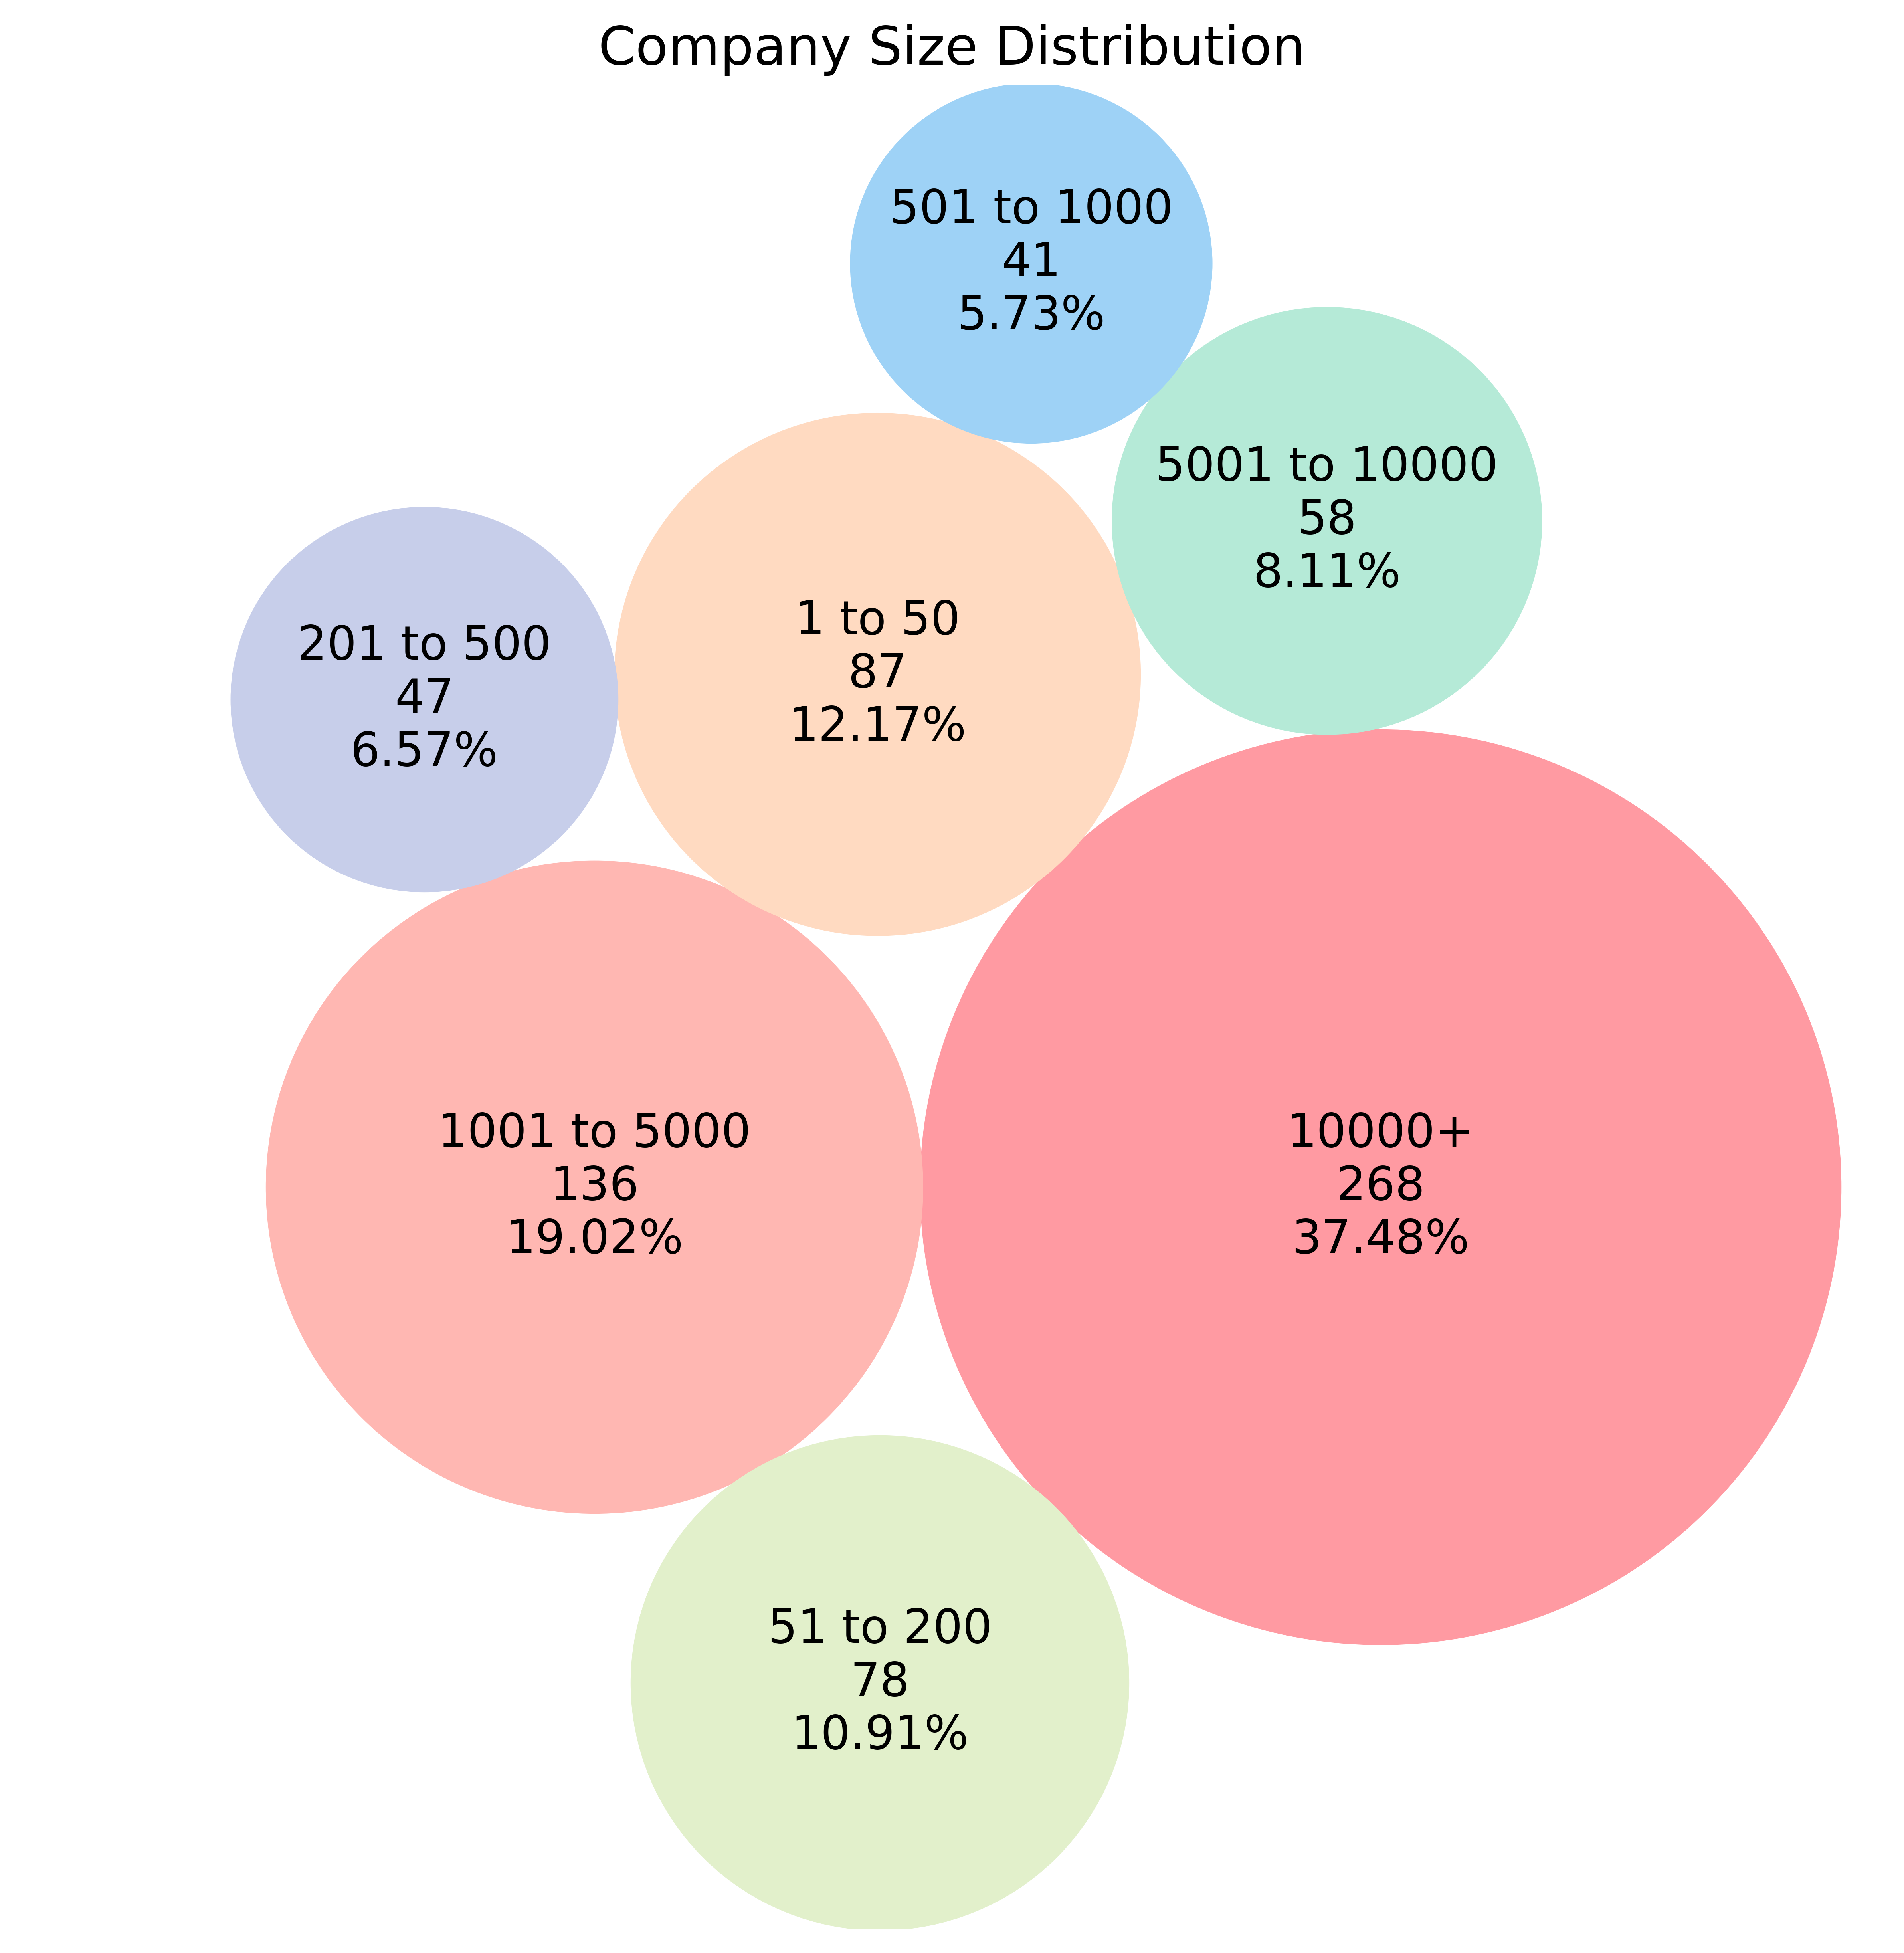

In [166]:
plt.rcParams['figure.dpi'] = 600
# 构建气泡列表
label = [i+'<br>'+str(j)+'<br>'+str(k)+'%' for i,j,k in zip(size_counts.index,
                                                            size_counts['count'],
                                                            size_counts.percentage)]
fig, ax = plt.subplots(figsize=(10,10), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

macaron_colors = ['#FF9AA2', '#FFB7B2', '#FFDAC1', '#E2F0CB', '#B5EAD7', '#C7CEEA', '#9ED2F6', '#A9DEF9']
# 以环绕方式绘图
for circle, note, color in zip(circles, label, macaron_colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=1, color = color))
    plt.annotate(note.replace('<br>','\n'), (x,y), size=14, va='center', ha='center')

plt.title('Company Size Distribution', fontsize=16)
plt.xticks([])
plt.yticks([])
plt.savefig('bubble_chart.png', dpi=600, bbox_inches='tight')

plt.show()

In [69]:
Analysis_df['type'].value_counts()

type
Company - Public                  313
Company - Private                 312
Nonprofit Organization             48
College / University               29
Subsidiary or Business Segment     21
Government                         18
Unknown                            10
Contract                            8
Hospital                            8
Self-employed                       5
Name: count, dtype: int64

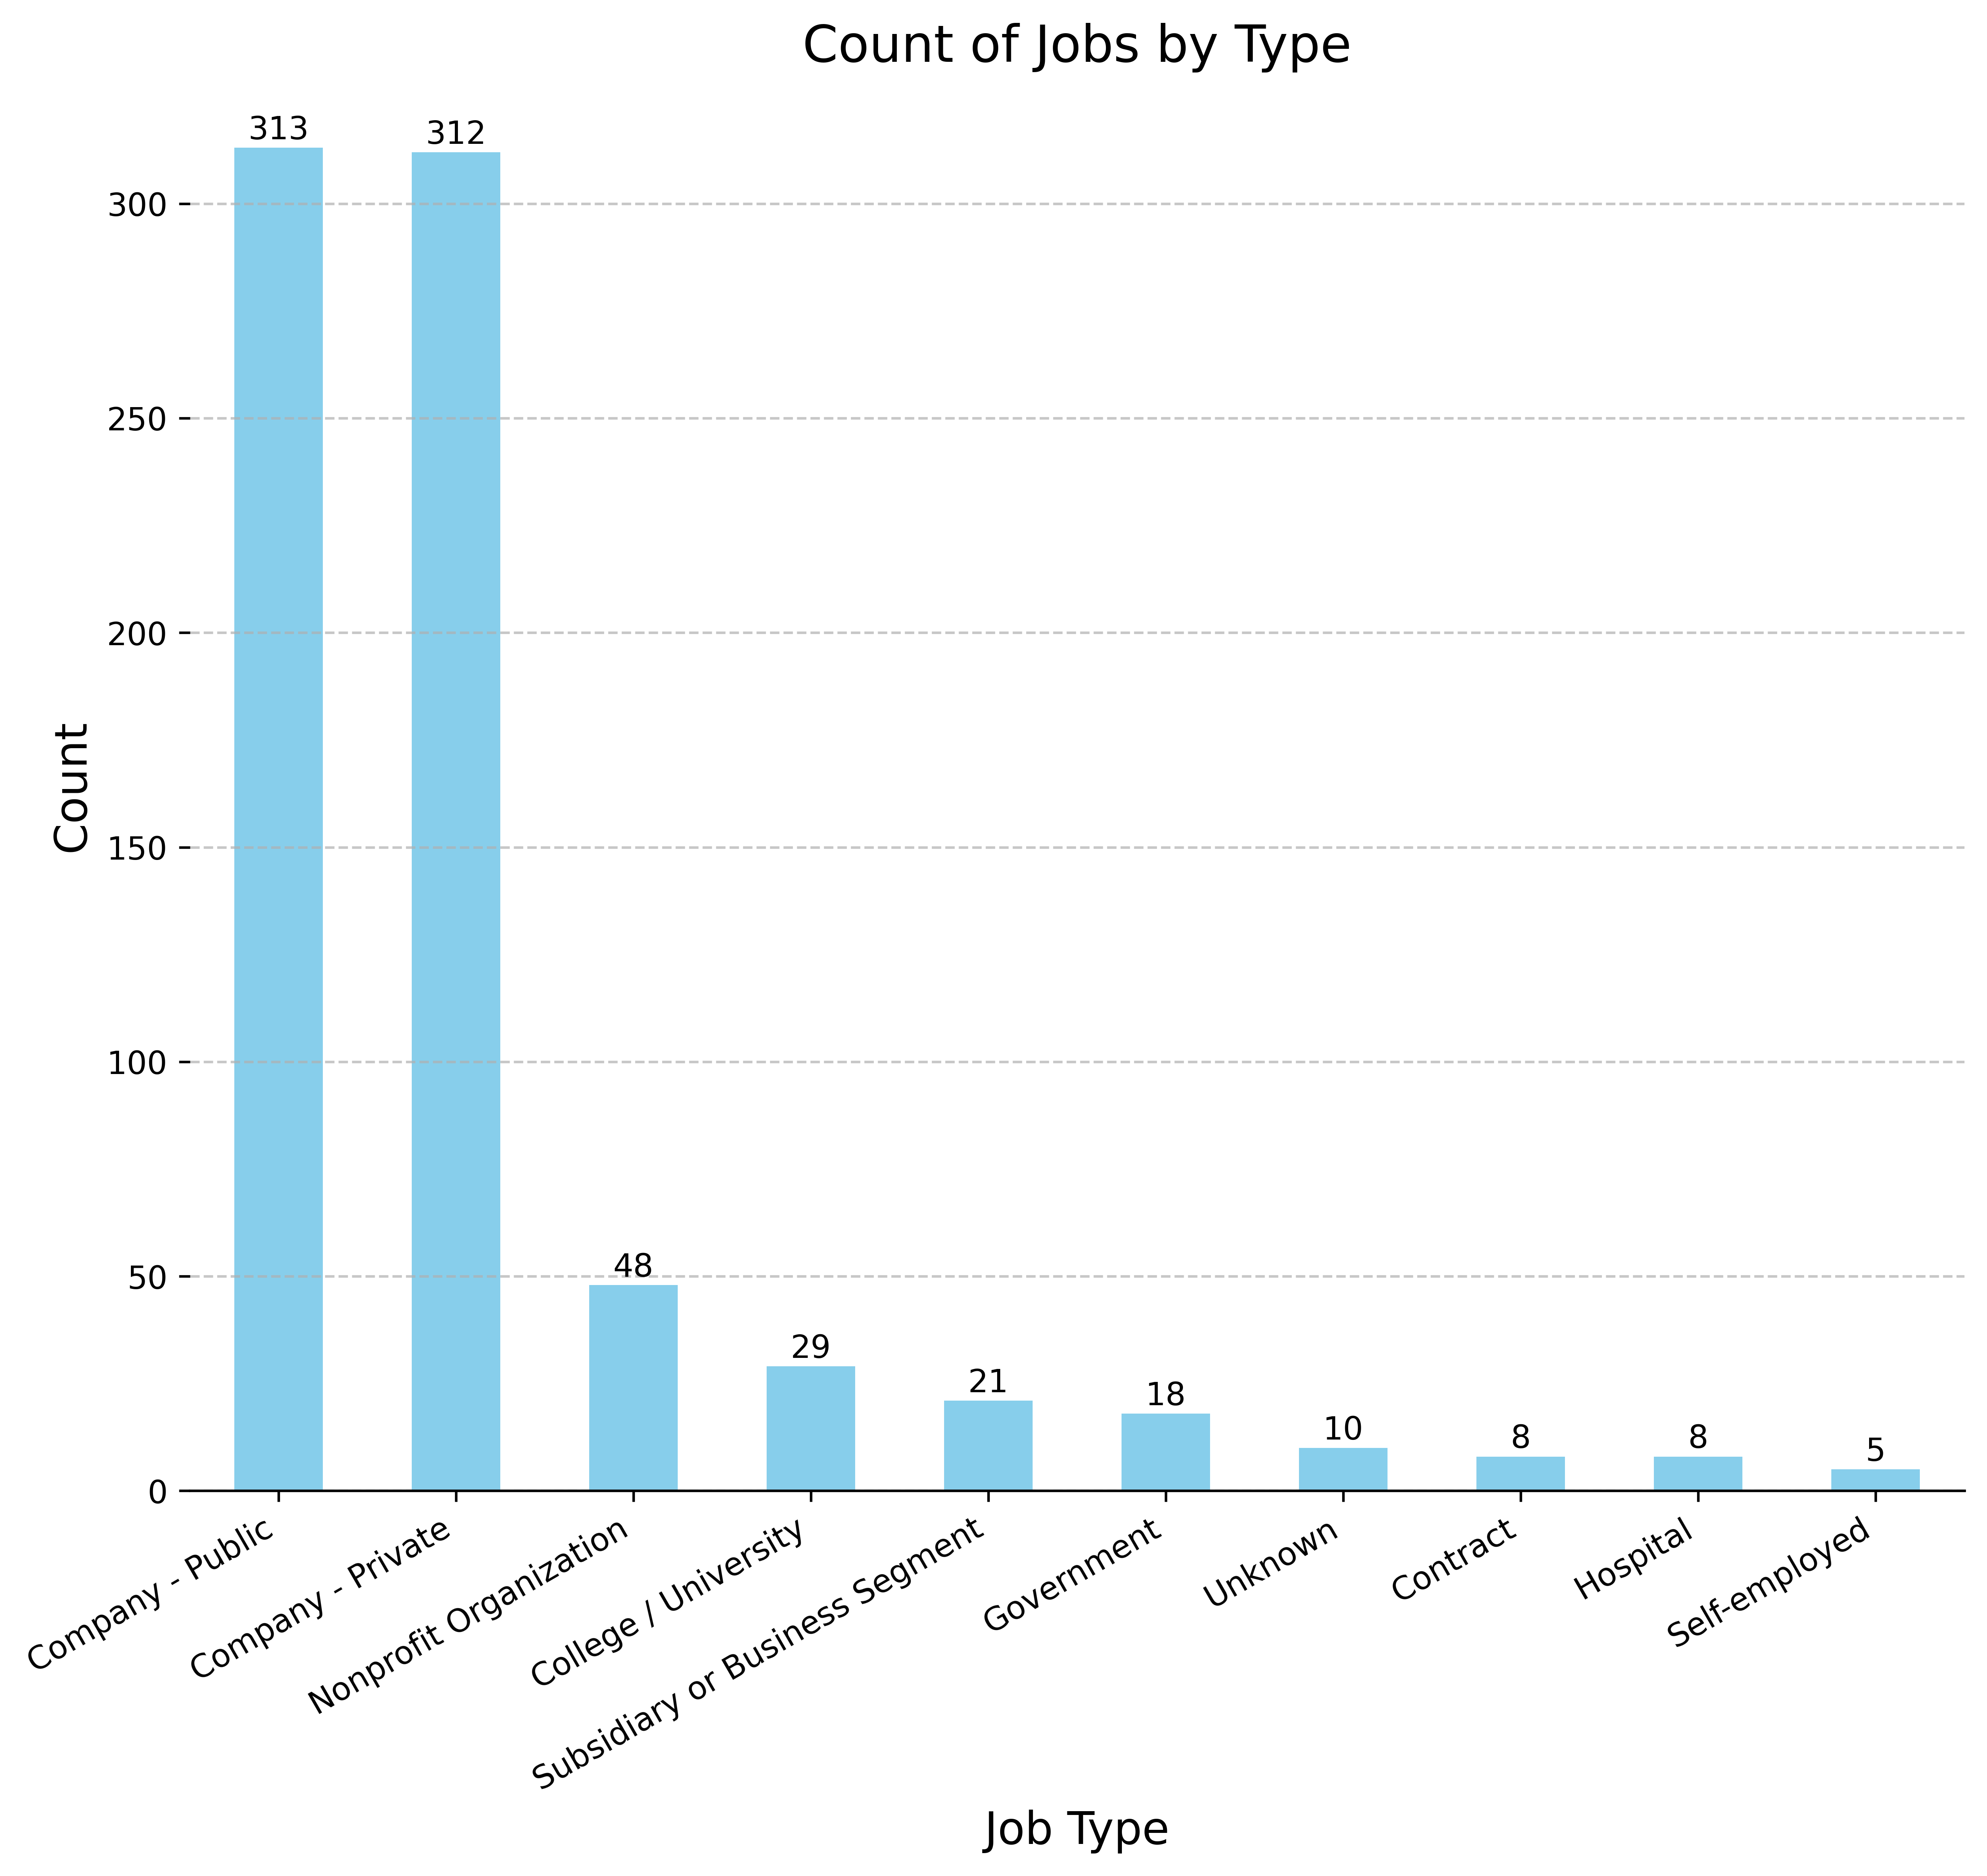

In [168]:
type_counts = Analysis_df['type'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))
plt.rcParams['figure.dpi'] = 600
ax = type_counts.plot(kind='bar', color='skyblue')
plt.ylabel('Count', fontsize=14)
plt.xlabel('Company Type', fontsize=14)
plt.title('Count of Jobs by Company Type', fontsize=16)
plt.xticks(rotation=30, ha='right', fontsize=10)

# Add labels to the bars
for i, v in enumerate(type_counts):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

# Customize plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

plt.savefig('job_type.png', dpi=600, bbox_inches='tight')   

plt.show()

In [ ]:
sector_counts = Analysis_df['sector'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Sector')
plt.title('Count of Jobs by Sector')
plt.show()

In [72]:
industry_table = Analysis_df['industry'].value_counts()

In [73]:
Analysis_df['sector'].value_counts()

sector
Information Technology                         258
--                                              58
Financial Services                              56
Management & Consulting                         49
Healthcare                                      46
Insurance                                       38
Manufacturing                                   35
Education                                       34
Pharmaceutical & Biotechnology                  32
Retail & Wholesale                              31
Government & Public Administration              24
Aerospace & Defense                             23
Media & Communication                           23
Energy, Mining & Utilities                      12
Transportation & Logistics                       8
Telecommunications                               7
Human Resources & Staffing                       7
Real Estate                                      5
Nonprofit & NGO                                  4
Legal                   

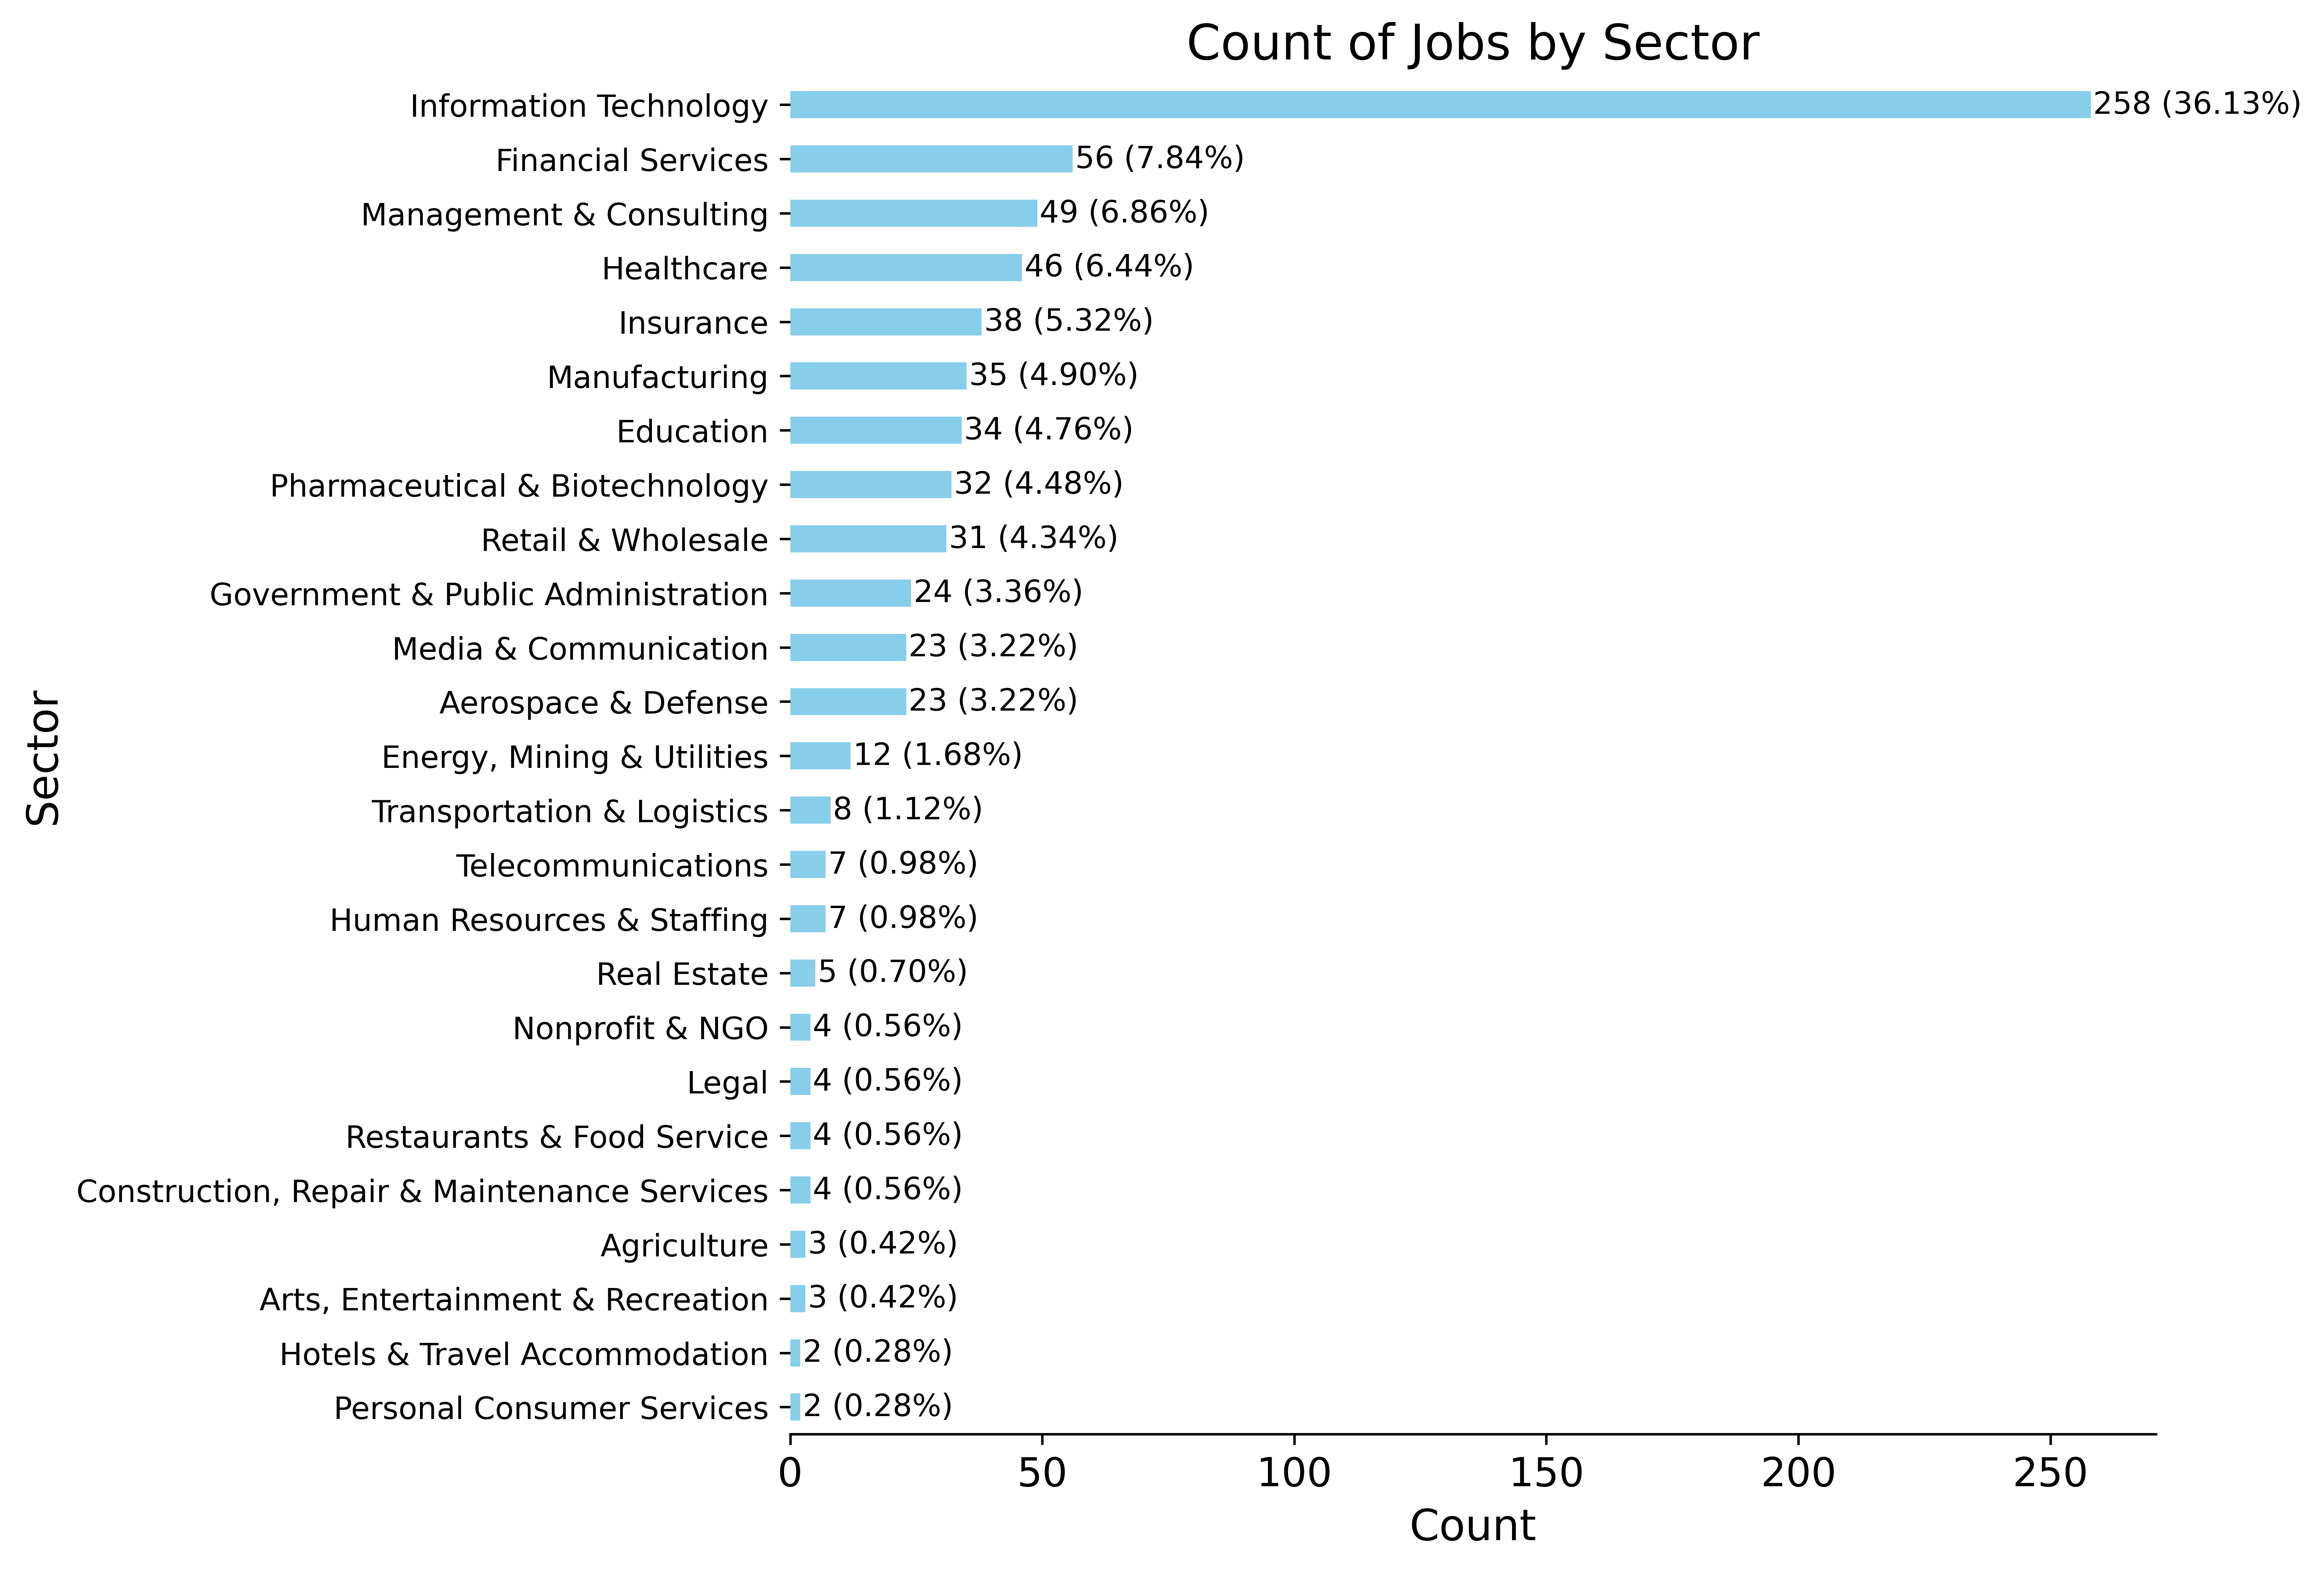

In [183]:
filtered_df = Analysis_df[Analysis_df['sector'] != '--']

sector_counts = filtered_df['sector'].value_counts()

total_jobs = sector_counts.sum()
sector_percentages = (sector_counts / total_jobs) * 100

sorted_sectors = sector_counts.sort_values(ascending=True)

plt.figure(figsize=(8, 8))
plt.rcParams['figure.dpi'] = 600
ax = sorted_sectors.plot(kind='barh', color='skyblue')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Sector', fontsize=14)
plt.title('Count of Jobs by Sector', fontsize=16)
plt.xticks(fontsize=13)

for i, v in enumerate(sorted_sectors):
    ax.text(v + 0.5, i, f'{v} ({sector_percentages[sorted_sectors.index[i]]:.2f}%)', color='black', va='center')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.xaxis.grid(True, linestyle='--', alpha=0.5)

plt.savefig('sector_count.png', bbox_inches='tight', dpi=600)

plt.show()

In [74]:
info_company = Analysis_df[Analysis_df['sector'] == 'Information Technology']
info_company['industry'].value_counts()

industry
Internet & Web Services                    69
Enterprise Software & Network Solutions    58
Computer Hardware Development              56
Information Technology Support Services    46
Software Development                       29
Name: count, dtype: int64

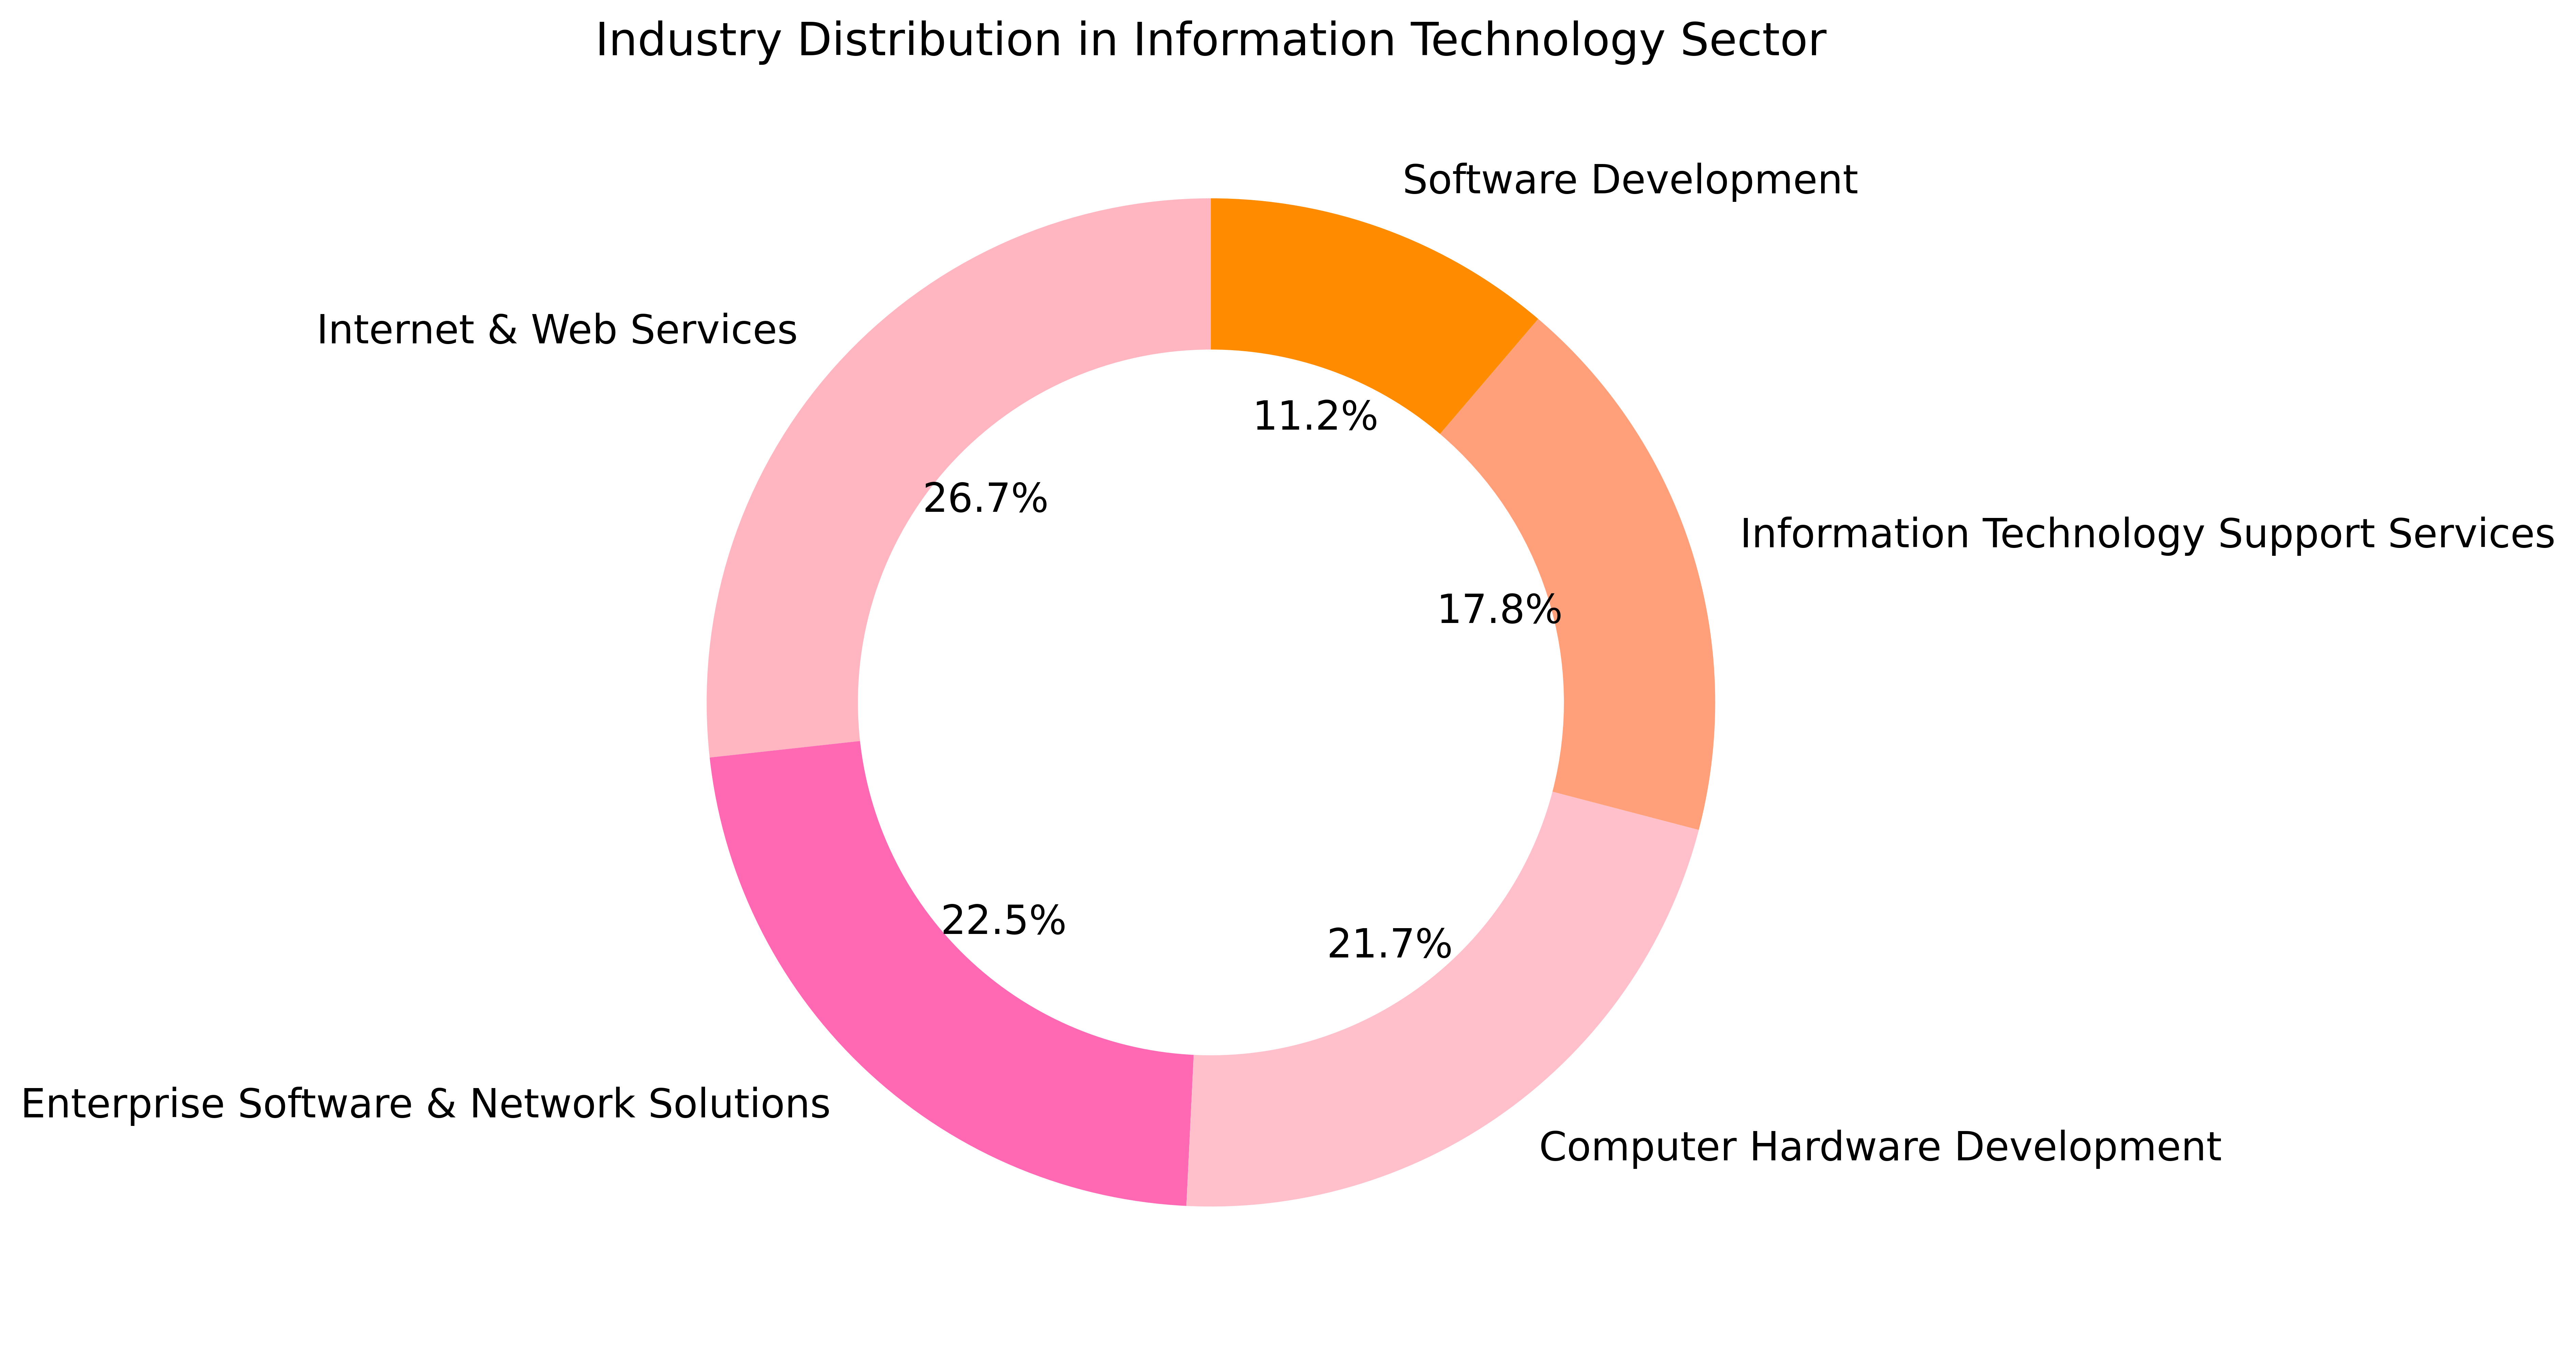

In [177]:
industry_counts = info_company['industry'].value_counts()

colors = ['#FFB6C1', '#FF69B4', '#FFC0CB', '#FFA07A', '#FF8C00']
# Plot a hollow pie chart
plt.figure(figsize=(8, 8))
plt.pie(industry_counts, labels=industry_counts.index, autopct='%1.1f%%', startangle=90,
         wedgeprops=dict(width=0.3), colors=colors, textprops={'fontsize': 14})
plt.title('Industry Distribution in Information Technology Sector', fontsize=18)

plt.savefig('industry_pie.png', dpi=600, bbox_inches='tight')
plt.show()

In [181]:
plt.figure(figsize=(20, 10))
plt.rcParams['figure.dpi'] = 600

plt.subplot(1, 2, 1)
ax = sorted_sectors.plot(kind='barh', color='skyblue')
plt.xlabel('Count', fontsize=16)
plt.ylabel('Sector', fontsize=16)
plt.title('Count of Jobs by Sector', fontsize=18)
plt.xticks(fontsize=14)

for i, v in enumerate(sorted_sectors):
    ax.text(v + 0.5, i, f'{v} ({sector_percentages[sorted_sectors.index[i]]:.2f}%)', color='black', va='center')

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.xaxis.grid(True, linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
colors = ['#FFB6C1', '#FF69B4', '#FFC0CB', '#FFA07A', '#FF8C00']
# Plot a hollow pie chart
plt.pie(industry_counts, labels=industry_counts.index, autopct='%1.1f%%', startangle=90,
         wedgeprops=dict(width=0.3), colors=colors, textprops={'fontsize': 14})
plt.title('Industry Distribution in Information Technology Sector', fontsize=18)

plt.savefig('sector_count.png', bbox_inches='tight', dpi=600)

plt.show()

In [80]:
grouped_company = Analysis_df.groupby('company_name').first()

In [84]:
grouped_company['founded'] = pd.to_numeric(grouped_company['founded'], errors='coerce')

In [85]:
company_founded = grouped_company.dropna(subset=['founded'])

In [149]:
company_founded['type'].value_counts().index    

Index(['Company - Private', 'Company - Public', 'Nonprofit Organization',
       'College / University', 'Subsidiary or Business Segment', 'Government',
       'Hospital', 'Unknown', 'Self-employed', 'Contract'],
      dtype='object', name='type')

In [89]:
company_founded.nlargest(5, 'founded')

job_title                    size  \
company_name                                                             
Actfore                             Reston, VA       1 to 50 Employees   
Ascendion            Machine Learning Engineer  1001 to 5000 Employees   
RVO Health            Data Scientist, Medicare  1001 to 5000 Employees   
Warner Bros Careers      Senior Data Scientist        10000+ Employees   
Dataworks                       Data Scientist       1 to 50 Employees   

                     founded               type  \
company_name                                      
Actfore               2022.0  Company - Private   
Ascendion             2022.0  Company - Private   
RVO Health            2022.0  Company - Private   
Warner Bros Careers   2022.0   Company - Public   
Dataworks             2021.0  Company - Private   

                                                    industry  \
company_name                                                   
Actfore              Information Technology Support Services   
Ascendion                               Software Development   
RVO Health                        Hospitals & Health Clinics   
Warner Bros Careers                          Film Production   
Dataworks            Information Technology Support Services   

                                     sector  
company_name                                 
Actfore              Information Technology  
Ascendion            Information Technology  
RVO Health                       Healthcare  
Warner Bros Careers   Media & Communication  
Dataworks            Information Technology

In [88]:
company_founded.nsmallest(5, 'founded')

job_title                     size  \
company_name                                                                    
NYC Careers                           DATA SCIENTIST                  Unknown   
Harvard University    Scientist I - Machine Learning         10000+ Employees   
Yale University                       Data Scientist         10000+ Employees   
Princeton University        Data Scientist Positions  5001 to 10000 Employees   
Columbia University                       AI Analyst         10000+ Employees   

                      founded                    type  \
company_name                                            
NYC Careers            1625.0              Government   
Harvard University     1636.0    College / University   
Yale University        1701.0  Nonprofit Organization   
Princeton University   1746.0    College / University   
Columbia University    1754.0    College / University   

                                     industry  \
company_name                                    
NYC Careers                Municipal Agencies   
Harvard University    Colleges & Universities   
Yale University       Colleges & Universities   
Princeton University  Colleges & Universities   
Columbia University   Colleges & Universities   

                                                  sector  
company_name                                              
NYC Careers           Government & Public Administration  
Harvard University                             Education  
Yale University                                Education  
Princeton University                           Education  
Columbia University                            Education

In [99]:
founded_time=pd.DataFrame()
founded_time['founded'] = company_founded['founded']

founded_time = founded_time.sort_values(by='founded')

founded_time['cumulative_count'] = range(1, len(founded_time) + 1)

In [155]:
company_founded_time['founded'] = company_founded[company_founded['type'].values in {'Company - Private','Company - Public'}]['founded']

TypeError: unhashable type: 'numpy.ndarray'

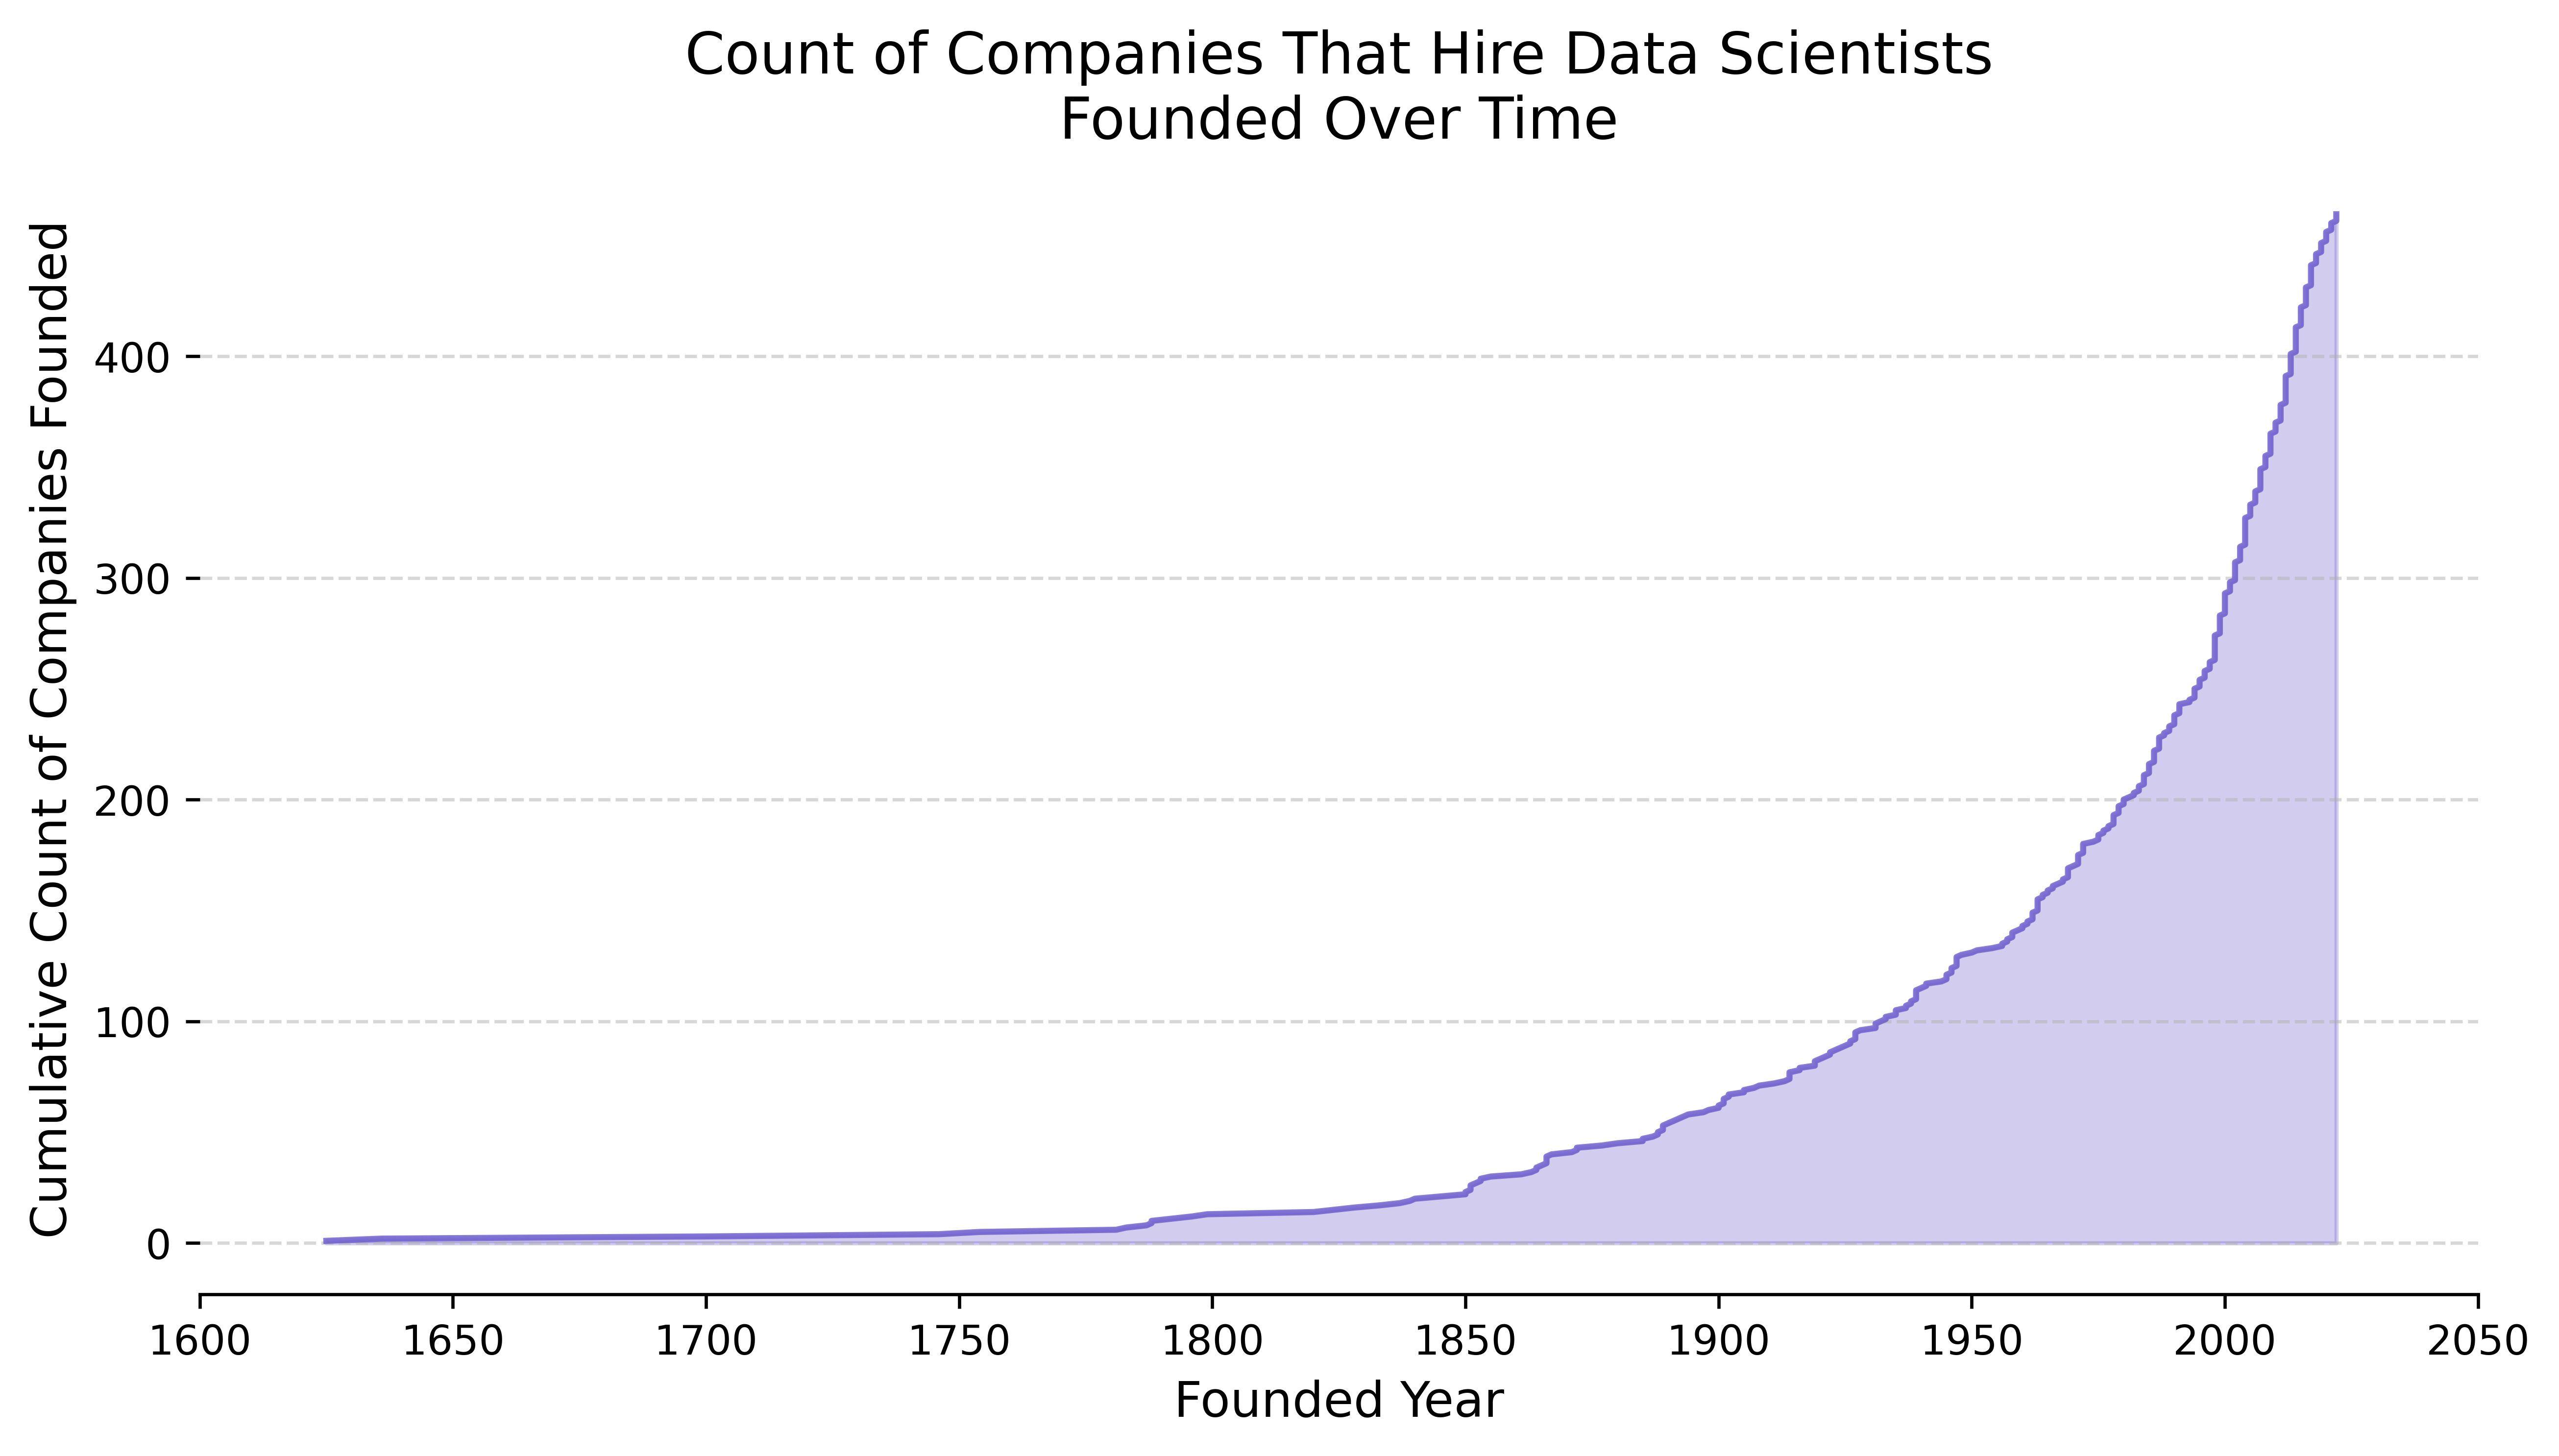

In [108]:
plt.figure(figsize=(10, 5))
plt.rcParams['figure.dpi'] = 600
plt.fill_between(founded_time['founded'], founded_time['cumulative_count'], color='Slateblue', alpha=0.3)
plt.plot(founded_time['founded'], founded_time['cumulative_count'], color='Slateblue', alpha=0.8)
plt.fill_between(founded_time['founded'], founded_time['cumulative_count'], color='skyblue', alpha=0.3)
plt.plot(founded_time['founded'], founded_time['cumulative_count'], color='Slateblue', alpha=0.8)
plt.xlabel('Founded Year', fontsize=12)
plt.ylabel('Cumulative Count of Companies Founded', fontsize=12)
plt.title('Count of Companies That Hire Data Scientists\nFounded Over Time', fontsize=14)
plt.xlim(1600, 2050)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# 设置仅显示横向边框
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('founded_time.png', dpi=600)
plt.show()

In [38]:
len(driver.find_elements(By.CLASS_NAME,'JobsList_jobListItem__wjTHv'))

61

In [24]:
job_title

'Activision\n3.6\nData Scientist\nSanta Monica, CA'